### Links para os datasets usados no tratamento
- (Original .csv) [dataset_sepsis.csv](https://drive.google.com/file/d/1UCDANKuyQpLRLxr8TMT8SvtElOBgC-V9/view?usp=drive_link)
- (Treino com PATIENT_ID .csv) [dataset_sepsis_train_pid.csv](https://drive.google.com/file/d/152sGYPxsoSGLmUJWgp-y2PmoT193at41/view?usp=drive_link)
- (Teste com PATIENT_ID .csv) [dataset_sepsis_test_pid.csv](https://drive.google.com/file/d/1ztzUwKVJjqaFjPJb2RoIlq8M0LMV5FrE/view?usp=drive_link)

## 1. Importação de Bibliotecas e Configurações

In [1]:
# Importações essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from scipy import stats

warnings.filterwarnings('ignore')


# Configurações de visualização
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


## (Opcional) 2. Carregamento e Split do Dataset Original
Célula usada somente uma vez para a criação da feature PATIENT_ID nos datasets de treino e teste. 

O output dos dataset com a criação dela foi guardado.

In [ ]:
# Carregar dataset original sem patient_id
print("\nDataset original com ordem de linha:")
df_full = pd.read_csv('dataset_sepsis.csv', na_values=['?'])
print(f"   Shape: {df_full.shape}")
print(f"   Total de registros: {len(df_full):,}")

# Fazer split com mesmo random_state e test_size para verificação
print("\nFazendo split do dataset original (random_state=42, test_size=0.2)...")

# Separar features e target
X_original = df_full.drop('SepsisLabel', axis=1)
y_original = df_full['SepsisLabel']

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_original, y_original, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_original
)

print(f"   Train split: {len(X_train_split):,} registros")
print(f"   Test split:  {len(X_test_split):,} registros")

# Carregar datasets atuais
df_train_atual = pd.read_csv('dataset_sepsis_train.csv', na_values=['?'])
df_test_atual = pd.read_csv('dataset_sepsis_test.csv', na_values=['?'])

print(f"Train atual: {df_train_atual.shape}] \n Test atual: {df_test_atual.shape}")



## 3. Carregamento dos Dados Para Tratamento

In [5]:

# Carregar datasets
print("\nCarregando datasets:")
name = 'dataset_sepsis_train'
df = pd.read_csv(name + '.csv')

print(f"   Train atual: {df.shape}")

print("\n Todos os datasets carregados!")


Carregando datasets:
   Train atual: (1241768, 43)

 Todos os datasets carregados!
   Train atual: (1241768, 43)

 Todos os datasets carregados!


In [6]:
# Análise dos valores missing do dataset original
print("ANÁLISE DE VALORES FALTANTES (Dataset Original):")
print("=" * 50)

missing_stats = pd.DataFrame({
    'Coluna': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df)) * 100
})

missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)
print(missing_stats.to_string(index=False))


ANÁLISE DE VALORES FALTANTES (Dataset Original):
          Coluna  Missing_Count  Missing_Percent
Bilirubin_direct        1239375        99.807291
      Fibrinogen        1233565        99.339410
       TroponinI        1230025        99.054332
 Bilirubin_total        1223250        98.508739
    Alkalinephos        1221814        98.393098
             AST        1221624        98.377797
         Lactate        1208530        97.323333
             PTT        1205078        97.045342
            SaO2        1198991        96.555154
           EtCO2        1195721        96.291819
       Phosphate        1191757        95.972597
            HCO3        1189434        95.785525
        Chloride        1185067        95.433849
      BaseExcess        1174444        94.578375
           PaCO2        1172636        94.432776
         Calcium        1168499        94.099622
       Platelets        1167978        94.057666
      Creatinine        1165959        93.895075
       Magnesium    

## (Opcional) 4. Atribuição e Verificação de Patient_ID ao Dataset para Tratamento
Durante os testes no tratamento, essa atribuição e verificação foi feita somente uma vez tanto para o treino como para o teste. 

Não é necessário rodar mais de uma vez, pois o resultado é armazenado num csv. 

Após isso o csv com a coluna PATIENT_ID pode ser carregado diretamente

In [ ]:
# Criar identificador único de paciente baseado em Hour + Age
print("CRIANDO IDENTIFICADOR DE PACIENTE (LÓGICA: Hour=0 + Age muda)")
print("=" * 70)

# Verificar se temos Hour e Age
if 'Hour' in df_full.columns and 'Age' in df_full.columns and 'PATIENT_ID' not in df_full.columns:
    # Lógica: quando Hour volta a 0 E Age muda, é outro paciente
    patient_id = 0
    patient_ids = []
    previous_age = None
    
    for idx, row in df_full.iterrows():
        current_hour = row['Hour']
        current_age = row['Age']
        
        # Se Hour é 0 E Age mudou em relação ao anterior, é novo paciente
        if current_hour == 0 and previous_age is not None and current_age != previous_age:
            patient_id += 1
        
        patient_ids.append(patient_id)
        previous_age = current_age
    
    df_full['PATIENT_ID'] = patient_ids
    
    print(f"PATIENT_ID criado com sucesso!")
    print(f"Total de pacientes únicos: {df_full['PATIENT_ID'].nunique():,}")
    print(f"Registros por paciente (média): {len(df_full) / df_full['PATIENT_ID'].nunique():.1f}")

In [ ]:
# Verificar se o split é o mesmo e adicionar PATIENT_ID aos datasets atuais
print("VERIFICAÇÃO E ATRIBUIÇÃO DE PATIENT_ID")
print("=" * 70)

# Reconstruir os datasets do split (com Patient_ID)
train_split_with_id = pd.concat([X_train_split, y_train_split], axis=1)
test_split_with_id = pd.concat([X_test_split, y_test_split], axis=1)

# Função para verificar e atribuir Patient_ID (versão vetorizada otimizada)
def verify_and_assign_patient_id(split_df, atual_df, dataset_name):
    """
    Compara vetorialmente o dataset do split com o atual usando pandas.
    """
    print(f"\n🔄 Processando {dataset_name}...")
    
    # Colunas para comparação (todas exceto PATIENT_ID)
    compare_cols = [col for col in split_df.columns if col != 'PATIENT_ID']
    
    # Resetar índices para garantir comparação linha a linha
    split_df_reset = split_df.reset_index(drop=True)
    atual_df_reset = atual_df.reset_index(drop=True)
    
    # Verificar se número de linhas é igual
    if len(split_df_reset) != len(atual_df_reset):
        print(f"    ERRO: Número de linhas diferente!")
        return None
    
    # Comparação vetorizada usando "!" como placeholder para NaN
    match_mask = (split_df_reset[compare_cols].fillna("!") == 
                  atual_df_reset[compare_cols].fillna("!")).all(axis=1)
    
    matches = match_mask.sum()
    mismatches = (~match_mask).sum()
    
    print(f"   Matches: {matches:,} ({matches/len(split_df_reset)*100:.2f}%)")
    
    if mismatches == 0:
        atual_df_with_id = atual_df_reset.copy()
        atual_df_with_id['PATIENT_ID'] = split_df_reset['PATIENT_ID'].values
        print(f"   100% de match. PATIENT_ID atribuído!")
        return atual_df_with_id
    else:
        print(f"   {mismatches:,} diferenças encontradas. Patient_ID não atribuído.")
        return None

# Verificar e atribuir para TREINO
df_train_with_id = verify_and_assign_patient_id(train_split_with_id, df_train_atual, "TREINO")

# Verificar e atribuir para TESTE
df_test_with_id = verify_and_assign_patient_id(test_split_with_id, df_test_atual, "TESTE")

print("\n" + "=" * 70)
if df_train_with_id is not None and df_test_with_id is not None:
    print("VERIFICAÇÃO CONCLUÍDA: Os splits são IDÊNTICOS!")
    print("PATIENT_ID atribuído aos datasets de treino e teste!")
    
    # Salvar datasets com Patient_ID
    df_train_with_id.to_csv('dataset_sepsis_train_with_patient_id.csv', index=False)
    df_test_with_id.to_csv('dataset_sepsis_test_with_patient_id.csv', index=False)
    
    print(f"\n Datasets salvos:")
    print(f"   dataset_sepsis_train_patient_id.csv")
    print(f"   dataset_sepsis_test_patient_id.csv")

    # Atualizar variáveis para usar nas próximas seções
    df_train_atual = df_train_with_id
    df_test_atual = df_test_with_id

## 5. Análise da Variável Target

In [37]:
# Análise da variável target (SepsisLabel)

def analyze_target_distribution(df):
    target_dist = df['SepsisLabel'].value_counts().sort_index()
    
    print("Distribuição da Variável Target:")
    for label, count in target_dist.items():
        percentage = (count / len(df)) * 100
        status = "Sem Sepsis" if label == 0 else "Com Sepsis"
        print(f"  {status} ({label}): {count:,} ({percentage:.1f}%)")
    
    # Calcular taxa de desbalanceamento
    imbalance_ratio = target_dist.max() / target_dist.min()
    print(f"\nTaxa de Desbalanceamento: {imbalance_ratio:.1f}:1")
    
    # Análise por paciente único
    patient_sepsis = df.groupby('PATIENT_ID')['SepsisLabel'].max()  # Se teve sepsis em algum momento
    patient_target_dist = patient_sepsis.value_counts().sort_index()
    
    print(f"\nDistribuição por Paciente Único:")
    for label, count in patient_target_dist.items():
        percentage = (count / len(patient_sepsis)) * 100
        status = "Nunca teve Sepsis" if label == 0 else "Teve Sepsis"
        print(f"  {status}: {count:,} pacientes ({percentage:.1f}%)")
    
    # Visualização
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Distribuição geral
    target_dist.plot(kind='bar', ax=axes[0], color=['lightblue', 'lightcoral'], alpha=0.8)
    axes[0].set_title('Distribuição Geral - SepsisLabel', fontweight='bold')
    axes[0].set_xlabel('SepsisLabel')
    axes[0].set_ylabel('Contagem')
    axes[0].set_xticklabels(['Sem Sepsis', 'Com Sepsis'], rotation=0)
    axes[0].grid(True, alpha=0.3)
    
    # Gráfico 2: Distribuição por paciente
    patient_target_dist.plot(kind='bar', ax=axes[1], color=['lightgreen', 'salmon'], alpha=0.8)
    axes[1].set_title('Distribuição por Paciente Único', fontweight='bold')
    axes[1].set_xlabel('Status de Sepsis')
    axes[1].set_ylabel('Número de Pacientes')
    axes[1].set_xticklabels(['Nunca teve', 'Teve Sepsis'], rotation=0)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

ANÁLISE DA VARIÁVEL TARGET (SepsisLabel)
Distribuição da Variável Target:
  Sem Sepsis (0.0): 1,219,435 (98.2%)
  Com Sepsis (1.0): 22,333 (1.8%)

Taxa de Desbalanceamento: 54.6:1

Distribuição por Paciente Único:
  Nunca teve Sepsis: 37,021 pacientes (92.7%)
  Teve Sepsis: 2,929 pacientes (7.3%)


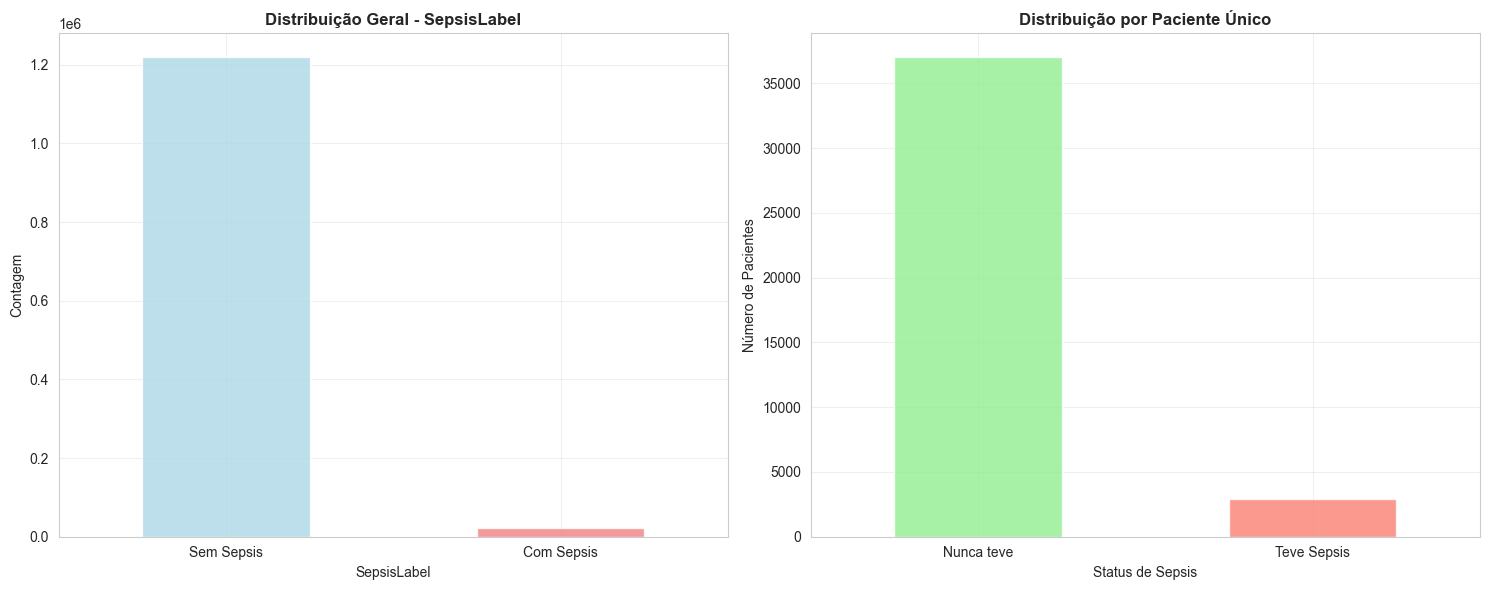

In [38]:
print("ANÁLISE DA VARIÁVEL TARGET (SepsisLabel)")
print("=" * 45)
analyze_target_distribution(df)

## 6 Análise de separabilidade (Fundamentar Seleção)

In [7]:

X_train = df.drop(columns=['SepsisLabel'])
y_train = df['SepsisLabel']

# Identificar variáveis com >60% missing
high_missing_vars = []
for col in X_train.select_dtypes(include=[np.number]).columns:
    missing_pct = (X_train[col].isnull().sum() / len(X_train)) * 100
    if missing_pct > 60:
        high_missing_vars.append({
            'variavel': col,
            'missing_pct': missing_pct
        })

# Calcular separabilidade para cada variável
separability_results = {
    'IMPUTAR': [],    # Separabilidade >=0.16 Discriminação mínima  
    'DESCARTAR': []            # Separabilidade < 0.16: Baixa discriminação
}

for var_info in high_missing_vars:
    col = var_info['variavel']
    missing_pct = var_info['missing_pct']
    
    # Criar DataFrame temporário sem valores faltantes
    temp_df = pd.DataFrame({
        'feature': X_train[col],
        'target': y_train
    }).dropna()

    # Separar por classe
    no_sepsis_data = temp_df[temp_df['target'] == 0]['feature']
    sepsis_data = temp_df[temp_df['target'] == 1]['feature']

    # Calcular separabilidade (diferença de medianas / desvio padrão)
    median_diff = abs(sepsis_data.median() - no_sepsis_data.median())
    pooled_std = no_sepsis_data.std() if no_sepsis_data.std() > 0 else 1
    separability = median_diff / pooled_std
    
    # Classificar baseado na separabilidade
    var_result = {
        'variavel': col,
        'missing_pct': missing_pct,
        'separabilidade': separability,
        'n_amostras': len(temp_df)
    }
    
    if separability >= 0.15:
        separability_results['IMPUTAR'].append(var_result)
    else:
        separability_results['DESCARTAR'].append(var_result)

# Exibir resultados 

for categoria, vars_list in separability_results.items():
    print(f"\n{categoria} ({len(vars_list)} variáveis):")
    for var in sorted(vars_list, key=lambda x: x['separabilidade'], reverse=True):
        print(f"  • {var['variavel']}: Sep={var['separabilidade']:.3f} | Missing={var['missing_pct']:.1f}% | n={var['n_amostras']:,}")

variables_to_treat = [var['variavel'] for var in separability_results['IMPUTAR']]  
variables_to_discard = [var['variavel'] for var in separability_results['DESCARTAR']]


IMPUTAR (6 variáveis):
  • Temp: Sep=0.393 | Missing=66.2% | n=419,945
  • BUN: Sep=0.353 | Missing=93.1% | n=85,440
  • Platelets: Sep=0.203 | Missing=94.1% | n=73,790
  • WBC: Sep=0.194 | Missing=93.6% | n=79,613
  • Hgb: Sep=0.152 | Missing=92.6% | n=91,759
  • Creatinine: Sep=0.151 | Missing=93.9% | n=75,809

DESCARTAR (22 variáveis):
  • pH: Sep=0.135 | Missing=93.1% | n=86,094
  • Fibrinogen: Sep=0.134 | Missing=99.3% | n=8,203
  • Hct: Sep=0.091 | Missing=91.1% | n=109,980
  • PTT: Sep=0.085 | Missing=97.0% | n=36,690
  • Calcium: Sep=0.083 | Missing=94.1% | n=73,269
  • Bilirubin_total: Sep=0.077 | Missing=98.5% | n=18,518
  • Alkalinephos: Sep=0.071 | Missing=98.4% | n=19,954
  • Phosphate: Sep=0.070 | Missing=96.0% | n=50,011
  • Bilirubin_direct: Sep=0.062 | Missing=99.8% | n=2,393
  • Lactate: Sep=0.048 | Missing=97.3% | n=33,238
  • Glucose: Sep=0.039 | Missing=82.9% | n=212,578
  • AST: Sep=0.015 | Missing=98.4% | n=20,144
  • Potassium: Sep=0.008 | Missing=90.7% | n=115

In [104]:
from scipy import stats
from sklearn.metrics import mutual_info_score

X_train_not_discard = X_train.drop(columns=variables_to_discard)
# Separar variáveis numéricas e categóricas
categorical_vars = ['Gender', 'Unit1', 'Unit2']  
# Numéricas são todas as colunas MENOS as categóricas
numeric_vars = [col for col in X_train_not_discard.columns if col not in categorical_vars]


# Análise para variáveis numéricas
all_separability_results = []

print(f"\nANÁLISE DE VARIÁVEIS NUMÉRICAS:")
print(f"{'Variável':<15} {'Missing%':<10} {'Separab.':<10} {'p-value_MW':<12} {'Mutual Info':<12} {'N_samples':<10}\n")

for var in numeric_vars:
    missing_pct = (X_train_not_discard[var].isnull().sum() / len(X_train_not_discard)) * 100
    
    # Criar DataFrame temporário sem valores faltantes
    temp_df = pd.DataFrame({
        'feature': X_train_not_discard[var],
        'target': y_train
    }).dropna()
    
    # Separar por classe
    no_sepsis_data = temp_df[temp_df['target'] == 0]['feature']
    sepsis_data = temp_df[temp_df['target'] == 1]['feature']

    # Calcular separabilidade (diferença de medianas / desvio padrão)
    median_diff = abs(sepsis_data.median() - no_sepsis_data.median())
    pooled_std = np.sqrt(((no_sepsis_data.std()**2 + sepsis_data.std()**2) / 2))
    separability = median_diff / pooled_std if pooled_std > 0 else 0
    
    # Teste U de Mann-Whitney (não-paramétrico)
    try:
        stat, p_value = stats.mannwhitneyu(sepsis_data, no_sepsis_data, alternative='two-sided')
        mann_whitney_pval = p_value
    except:
        mann_whitney_pval = 1.0  # p-value máximo para casos de erro

    # Informação mútua
    try:
        # Discretizar para mutual info (usar quintis)
        temp_df['feature_disc'] = pd.qcut(temp_df['feature'], q=5, labels=False, duplicates='drop')
        mutual_info = mutual_info_score(temp_df['target'], temp_df['feature_disc'])
    except:
        mutual_info = 0
    
    # Armazenar resultados
    result = {
        'variavel': var,
        'missing_pct': missing_pct,
        'separabilidade': separability,
        'mann_whitney': mann_whitney_pval,
        'mutual_info': mutual_info,
        'n_amostras': len(temp_df)
    }
    all_separability_results.append(result)
    
    # Exibir resultado
    print(f"{var:<15} {missing_pct:<10.1f} {separability:<10.3f} {mann_whitney_pval:<12.5f} {mutual_info:<12.7f} {len(temp_df):<10,}")


# Análise para variáveis categóricas
print(f"\nANÁLISE DE VARIÁVEIS CATEGÓRICAS:")
print(f"{'Variável':<15} {'Missing%':<10} {'p-value_Chi2':<12} {'Mutual Info':<12} {'N_samples':<10}\n")

for var in categorical_vars:
    missing_pct = (X_train_not_discard[var].isnull().sum() / len(X_train_not_discard)) * 100
    
    # Criar DataFrame temporário sem valores faltantes
    temp_df = pd.DataFrame({
        'feature': X_train_not_discard[var],
        'target': y_train
    }).dropna()
    
    # Teste Qui-quadrado
    try:
        contingency_table = pd.crosstab(temp_df['feature'], temp_df['target'])
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        chi2_pval = p_value
    except:
        chi2_pval = 1.0  # p-value máximo para casos de erro
    
    # Informação mútua
    try:
        mutual_info = mutual_info_score(temp_df['target'], temp_df['feature'])
    except:
        mutual_info = 0
    
    result = {
        'variavel': var,
        'missing_pct': missing_pct,
        'chi2_sig': chi2_pval,
        'mutual_info': mutual_info,
        'n_amostras': len(temp_df),
        'tipo': 'categorical'
    }
    all_separability_results.append(result)
    
    print(f"{var:<15} {missing_pct:<10.1f} {chi2_pval:<12.5f} {mutual_info:<12.7f} {len(temp_df):<10,}")


# Ranking por separabilidade (variáveis numéricas)
numeric_results = [r for r in all_separability_results if 'separabilidade' in r]
numeric_results_sorted = sorted(numeric_results, key=lambda x: x['separabilidade'], reverse=True)

print(f"\nSeparabilidades Numéricas:")
separabilities = [r['separabilidade'] for r in numeric_results]
print(f"  • Variáveis com Sep > 0.3: {sum(1 for s in separabilities if s > 0.3)}")
print(f"  • Variáveis com Sep > 0.16: {sum(1 for s in separabilities if s > 0.16)}")

# Análise de significância estatística
print(f"\nSIGNIFICÂNCIA ESTATÍSTICA (Numéricas):")
sig_001 = sum(1 for r in numeric_results if r['mann_whitney'] < 0.001)
sig_01 = sum(1 for r in numeric_results if 0.001 <= r['mann_whitney'] < 0.01)
sig_05 = sum(1 for r in numeric_results if 0.01 <= r['mann_whitney'] < 0.05)
not_sig = sum(1 for r in numeric_results if r['mann_whitney'] >= 0.05)
print(f"  • p < 0.001 (altamente significativo): {sig_001} variáveis")
print(f"  • 0.001 ≤ p < 0.01 (muito significativo): {sig_01} variáveis")  
print(f"  • 0.01 ≤ p < 0.05 (significativo): {sig_05} variáveis")
print(f"  • p ≥ 0.05 (não significativo): {not_sig} variáveis")

# Salvar resultados para uso posterior
statistical_analysis_results = {
    'numeric_results': numeric_results_sorted,
    'all_results': all_separability_results
}


ANÁLISE DE VARIÁVEIS NUMÉRICAS:
Variável        Missing%   Separab.   p-value_MW   Mutual Info  N_samples 

Hour            0.0        0.303      0.00000      0.0038413    1,241,768 
Hour            0.0        0.303      0.00000      0.0038413    1,241,768 
HR              9.9        0.386      0.00000      0.0010304    1,119,123 
HR              9.9        0.386      0.00000      0.0010304    1,119,123 
O2Sat           13.1       0.000      0.00079      0.0000634    1,079,708 
Temp            66.2       0.326      0.00000      0.0020082    419,945   
O2Sat           13.1       0.000      0.00079      0.0000634    1,079,708 
Temp            66.2       0.326      0.00000      0.0020082    419,945   
SBP             14.6       0.124      0.00000      0.0001972    1,060,857 
SBP             14.6       0.124      0.00000      0.0001972    1,060,857 
MAP             12.4       0.121      0.00000      0.0002270    1,087,236 
MAP             12.4       0.121      0.00000      0.0002270    1,

## 7. Imputação por Paciente (Limpeza Principal)

In [9]:
# Identificar colunas numéricas para imputação (excluindo ID e target)
cols_to_exclude = ['PATIENT_ID', 'SepsisLabel']
cols_to_impute = [ col for col in df.columns.to_list() if col not in cols_to_exclude]

print("IMPUTAÇÃO POR PACIENTE")
print("=" * 40)
print(f"Colunas numéricas para imputação: {len(cols_to_impute)}")
print(f"Colunas: {cols_to_impute[:5]}...")

# Criar cópia do dataframe para imputação
df_imputed = df.copy()

# Função de imputação por paciente
def impute_patient_data(patient_data):
    """
    Aplica imputação inteligente para um paciente específico:
    1. Ordenar por Hour (essencial para imputação temporal correta)
    2. Forward fill (propagar último valor válido temporalmente)
    3. Backward fill (propagar próximo valor válido temporalmente)
    """
    patient_imputed = patient_data.copy()
    
    # CRÍTICO: Ordenar por Hour para garantir ordem temporal correta
    if 'Hour' in patient_imputed.columns:
        patient_imputed = patient_imputed.sort_values('Hour').reset_index(drop=True)
    
    for col in cols_to_impute:
        if col in patient_imputed.columns:
            # 1. Forward fill (propaga valores temporalmente para frente)
            patient_imputed[col] = patient_imputed[col].fillna(method='ffill')
            
            # 2. Backward fill (propaga valores temporalmente para trás)
            patient_imputed[col] = patient_imputed[col].fillna(method='bfill')
    
    return patient_imputed

# Aplicar imputação por paciente
print("\nAplicando imputação por paciente...")

imputed_patients = []
total_patients = df_imputed['PATIENT_ID'].nunique()

for i, (patient_id, patient_data) in enumerate(df_imputed.groupby('PATIENT_ID')):
    if i % 1000 == 0:  # Progress indicator
        print(f"   Processando paciente {i+1}/{total_patients} ({(i+1)/total_patients*100:.1f}%)")
    
    imputed_patient = impute_patient_data(patient_data)
    imputed_patients.append(imputed_patient)

# Combinar todos os pacientes imputados
df_imputed = pd.concat(imputed_patients, ignore_index=True)

print(f"Imputação por paciente concluída!")

IMPUTAÇÃO POR PACIENTE
Colunas numéricas para imputação: 41
Colunas: ['Hour', 'HR', 'O2Sat', 'Temp', 'SBP']...

Aplicando imputação por paciente...
   Processando paciente 1/39950 (0.0%)
   Processando paciente 1/39950 (0.0%)
   Processando paciente 1001/39950 (2.5%)
   Processando paciente 1001/39950 (2.5%)
   Processando paciente 2001/39950 (5.0%)
   Processando paciente 2001/39950 (5.0%)
   Processando paciente 3001/39950 (7.5%)
   Processando paciente 3001/39950 (7.5%)
   Processando paciente 4001/39950 (10.0%)
   Processando paciente 4001/39950 (10.0%)
   Processando paciente 5001/39950 (12.5%)
   Processando paciente 5001/39950 (12.5%)
   Processando paciente 6001/39950 (15.0%)
   Processando paciente 6001/39950 (15.0%)
   Processando paciente 7001/39950 (17.5%)
   Processando paciente 7001/39950 (17.5%)
   Processando paciente 8001/39950 (20.0%)
   Processando paciente 8001/39950 (20.0%)
   Processando paciente 9001/39950 (22.5%)
   Processando paciente 9001/39950 (22.5%)
   Pro

In [10]:
# Comparar missing values antes e depois da imputação por paciente
print("📊 COMPARAÇÃO: ANTES vs DEPOIS DA IMPUTAÇÃO POR PACIENTE")
print("=" * 60)

missing_before = df[cols_to_impute].isnull().sum()
missing_after = df_imputed[cols_to_impute].isnull().sum()

comparison = pd.DataFrame({
    'Coluna': cols_to_impute,
    'Missing_Antes': missing_before.values,
    'Missing_Depois': missing_after.values,
    'Redução': missing_before.values - missing_after.values,
    'Redução_%': ((missing_before.values - missing_after.values) / missing_before.values * 100).round(1)
})

# Mostrar apenas colunas que tinham missing values
comparison_filtered = comparison[comparison['Missing_Antes'] > 0].sort_values('Redução_%', ascending=False)

if len(comparison_filtered) > 0:
    print(comparison_filtered.to_string(index=False))
    
    total_missing_before = missing_before.sum()
    total_missing_after = missing_after.sum()
    total_reduction = ((total_missing_before - total_missing_after) / total_missing_before * 100)
    
    print(f"\n📈 RESUMO GERAL:")
    print(f"   Total missing antes: {total_missing_before:,}")
    print(f"   Total missing depois: {total_missing_after:,}")
    print(f"   Redução total: {total_reduction:.1f}%")
else:
    print("✅ Nenhum valor faltante encontrado nas colunas numéricas!")

📊 COMPARAÇÃO: ANTES vs DEPOIS DA IMPUTAÇÃO POR PACIENTE
          Coluna  Missing_Antes  Missing_Depois  Redução  Redução_%
              HR         122645             146   122499       99.9
           O2Sat         162060             398   161662       99.8
            Temp         821823            7532   814291       99.1
            Resp         190587            1915   188672       99.0
             MAP         154532            2533   151999       98.4
             SBP         180911            9142   171769       94.9
         Glucose        1029190           60250   968940       94.1
       Potassium        1125868           78000  1047868       93.1
             BUN        1156328           92614  1063714       92.0
             Hct        1131788           91930  1039858       91.9
      Creatinine        1165959           98472  1067487       91.6
             Hgb        1150009          100552  1049457       91.3
             WBC        1162155          109820  1052335    

In [11]:
missing_stats_imputation = pd.DataFrame({
    'Coluna': df_imputed.columns,
    'Missing_Count': df_imputed.isnull().sum(),
    'Missing_Percent': (df_imputed.isnull().sum() / len(df_imputed)) * 100
})

missing_stats = missing_stats_imputation[missing_stats_imputation['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)
print(missing_stats.to_string(index=False))

          Coluna  Missing_Count  Missing_Percent
Bilirubin_direct        1169611        94.189172
           EtCO2        1115619        89.841178
      Fibrinogen        1086092        87.463359
       TroponinI        1034799        83.332716
         Lactate         817435        65.828319
            SaO2         806519        64.949250
      BaseExcess         803377        64.696223
 Bilirubin_total         798385        64.294216
    Alkalinephos         797962        64.260152
             AST         793141        63.871915
            FiO2         640398        51.571469
           PaCO2         632161        50.908141
            HCO3         622322        50.115803
             PTT         617139        49.698414
              pH         613945        49.441200
        Chloride         583378        46.979629
           Unit1         485088        39.064302
           Unit2         485088        39.064302
       Phosphate         367608        29.603597
             DBP    

In [105]:
# Ver coeficientes de correlacao 
corr_matrix = df_imputed.corr()
sepsis_corr = corr_matrix['SepsisLabel'].sort_values(ascending=False)
print("COEFICIENTES DE CORRELAÇÃO COM SEPSISLABEL:")
print(sepsis_corr.to_string())

COEFICIENTES DE CORRELAÇÃO COM SEPSISLABEL:
SepsisLabel         1.000000
ICULOS              0.135125
Hour                0.135049
Temp                0.049405
HR                  0.049259
BUN                 0.043260
Resp                0.042931
Bilirubin_direct    0.041606
Fibrinogen          0.031993
WBC                 0.030676
Bilirubin_total     0.028442
Unit1               0.024347
Creatinine          0.017731
BaseExcess          0.015266
Magnesium           0.013931
Glucose             0.011469
PTT                 0.010930
TroponinI           0.010532
pH                  0.010219
Gender              0.009526
Phosphate           0.007018
AST                 0.006660
SaO2                0.006513
Alkalinephos        0.005962
Lactate             0.000944
Age                 0.000583
PaCO2               0.000458
Potassium           0.000390
FiO2                0.000024
Chloride           -0.000042
HCO3               -0.001685
Platelets          -0.003860
O2Sat              -0.008672

## 8.1 Selecao de variaveis

In [ ]:
# Colunas para remover
# pH
# Fibrinogen
# PTT
# Calcium
# Bilirubin_total
# Alkalinephos
# Phosphate
# Bilirubin_direct
# Lactate
# AST
# TroponinI
# EtCO2
# BaseExcess
# HCO3
# FiO2
# PaCO2
# SaO2
# Chloride
# Magnesium


df_dropped = df_imputed.copy()

# Missing + Separabilidade
columns_to_drop = ['pH', 'Fibrinogen', 'PTT', 'Calcium', 'Bilirubin_total', 'Alkalinephos', 'Phosphate', 
                   'Bilirubin_direct', 'Lactate', 'AST', 'Chloride', 'TroponinI', 'EtCO2', 
                   'BaseExcess', 'HCO3', 'FiO2', 'PaCO2', 'SaO2', 'Chloride', 'Magnesium']


# Alto missing
columns_to_drop += ['Unit1', 'Unit2']

# Baixa separabilidade
columns_to_drop += ['Age', 'Potassium']

# Usar somente map para minimizar redundância -> dropar sbp e dbp
columns_to_drop += ['SBP', 'DBP']

# Dropar patient_id visto que não é feature preditiva (será excluída antes do salvamento dos dados)
# columns_to_drop += ['PATIENT_ID']


print("\nREMOVENDO COLUNAS COM ALTA TAXA DE MISSING OU BAIXA IMPORTÂNCIA")
df_dropped.drop(columns=columns_to_drop, inplace=True)
print(f"Colunas removidas. Novo shape: {df_dropped.shape}")


REMOVENDO COLUNAS COM ALTA TAXA DE MISSING OU BAIXA IMPORTÂNCIA
Colunas removidas. Novo shape: (1241768, 18)


## 8.2 Análise de Resultado Pós Seleção

ANÁLISE DAS COLUNAS RESTANTES APÓS SELEÇÃO DE VARIÁVEIS

📋 Total de variáveis mantidas: 16
   • Numéricas: 13
   • Categóricas: 1


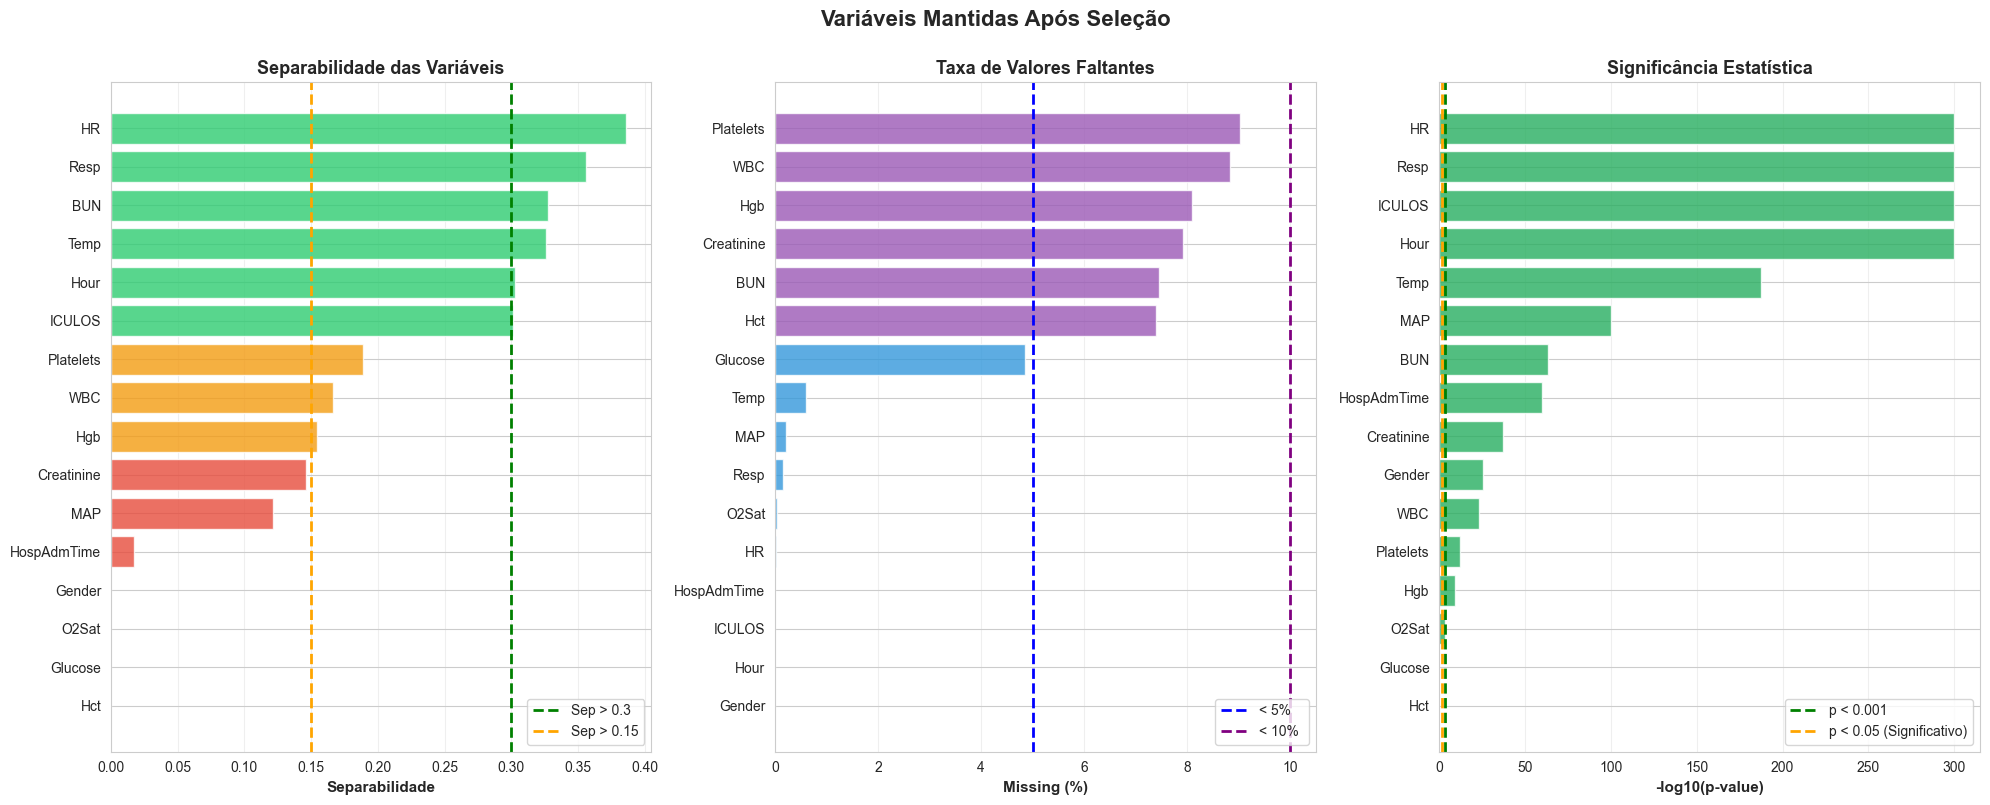


RESUMO ESTATÍSTICO:
   • Separabilidade média: 0.175
   • Missing % médio: 3.41%
   • Variáveis com Sep > 0.3: 6
   • Variáveis com Sep > 0.16: 8
   • Variáveis significativas (p < 0.05): 14
   • Variáveis altamente significativas (p < 0.001): 14

📋 TABELA RESUMO
   Variável  Missing_%  Separabilidade       p_value
         HR   0.011757        0.385740  0.000000e+00
       Resp   0.154216        0.355903  0.000000e+00
        BUN   7.458237        0.327827  5.830790e-64
       Temp   0.606555        0.326033 2.543567e-188
       Hour   0.000000        0.303036  0.000000e+00
     ICULOS   0.000000        0.301585  0.000000e+00
  Platelets   9.026243        0.189274  1.524191e-12
        WBC   8.843842        0.166232  8.635112e-24
        Hgb   8.097487        0.154650  7.923419e-10
 Creatinine   7.929984        0.146551  1.681666e-37
        MAP   0.203983        0.121410 9.481786e-101
HospAdmTime   0.000483        0.017071  1.751665e-60
     Gender   0.000000        0.000046  2.7368

In [108]:
# ======================================================================
# VISUALIZAÇÃO DAS COLUNAS RESTANTES APÓS SELEÇÃO
# ======================================================================

print("ANÁLISE DAS COLUNAS RESTANTES APÓS SELEÇÃO DE VARIÁVEIS")
print("=" * 70)

# Preparar dados para visualização
df_analysis = df_dropped.copy()
remaining_cols = [col for col in df_analysis.columns if col not in ['SepsisLabel', 'PATIENT_ID']]

# Calcular estatísticas para cada coluna
viz_data = []

for col in remaining_cols:
    # Missing values
    missing_pct = (df_analysis[col].isnull().sum() / len(df_analysis)) * 100
    
    # Separabilidade (se for numérica)
    if col in numeric_vars:
        # Buscar separabilidade nos resultados já calculados
        sep_result = next((r for r in statistical_analysis_results['numeric_results'] 
                          if r['variavel'] == col), None)
        
        if sep_result:
            separability = sep_result['separabilidade']
            mann_whitney = sep_result['mann_whitney']
        else:
            separability = 0
            mann_whitney = 1.0
    else:
        # Para variáveis categóricas, usar mutual info como proxy
        cat_result = next((r for r in all_separability_results 
                          if r.get('variavel') == col and r.get('tipo') == 'categorical'), None)
        
        if cat_result:
            separability = cat_result['mutual_info']
            mann_whitney = cat_result.get('chi2_sig', 1.0)
        else:
            separability = 0
            mann_whitney = 1.0
    
    viz_data.append({
        'Variável': col,
        'Missing_%': missing_pct,
        'Separabilidade': separability,
        'p_value': mann_whitney
    })

# Criar DataFrame para visualização
viz_df = pd.DataFrame(viz_data)
viz_df = viz_df.sort_values('Separabilidade', ascending=False)

print(f"\n📋 Total de variáveis mantidas: {len(remaining_cols)}")
print(f"   • Numéricas: {sum(1 for col in remaining_cols if col in numeric_vars)}")
print(f"   • Categóricas: {sum(1 for col in remaining_cols if col in categorical_vars)}")

# Criar visualização
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

###### Gráfico 1: Separabilidade
colors_sep = ['#2ecc71' if s >= 0.3 else '#f39c12' if s >= 0.15 else '#e74c3c' 
             for s in viz_df['Separabilidade']]

axes[0].barh(viz_df['Variável'], viz_df['Separabilidade'], color=colors_sep, alpha=0.8)
axes[0].axvline(x=0.3, color='green', linestyle='--', linewidth=2, label='Sep > 0.3')
axes[0].axvline(x=0.15, color='orange', linestyle='--', linewidth=2, label='Sep > 0.15')
axes[0].set_xlabel('Separabilidade', fontweight='bold', fontsize=11)
axes[0].set_title('Separabilidade das Variáveis', fontweight='bold', fontsize=13)
axes[0].legend(loc='lower right')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

###### Gráfico 2: Missing % em ordem decrescente
### plotar somente df_missing
# fig, ax = plt.subplots(figsize=(16, 12))

# # Ordenar dados por missing %
# viz_df_missing = viz_df.sort_values('Missing_%', ascending=True)

# # Criar barplot
# bars = ax.barh(viz_df_missing['Variável'], viz_df_missing['Missing_%'], 
#                color=sns.color_palette('rocket_r', len(viz_df_missing)))
# # Adicionar valores de missing % em cada barra
# for idx, (bar, missing_val) in enumerate(zip(bars, viz_df_missing['Missing_%'])):
#     width = bar.get_width()
#     ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
#             f'{missing_val:.1f}%',
#             ha='left', va='center', fontweight='bold', fontsize=12)

# # Linhas de referência
# ax.axvline(x=10, color='green', linestyle='--', linewidth=2, label='10% Missing')
# ax.axvline(x=60, color='orange', linestyle='--', linewidth=2, label='60% Missing')
# ax.axvline(x=90, color='red', linestyle='--', linewidth=2, label='90% Missing')

# # Configurações dos eixos e labels
# ax.set_xlabel('Missing (%)', fontweight='bold', fontsize=14)
# ax.set_ylabel('Variável', fontweight='bold', fontsize=14)
# ax.set_title('Missing Por Variável', fontweight='bold', fontsize=16)

# # Labels dos eixos em negrito
# ax.tick_params(axis='both', which='major', labelsize=11)
# for label in ax.get_xticklabels():
#     label.set_fontweight('bold')
# for label in ax.get_yticklabels():
#     label.set_fontweight('bold')

# ax.grid(False)  # Remove grid lines
# ax.legend(loc='lower right', fontsize=11)
# plt.tight_layout()
# plt.show()

### Plotar junto com os outros gráficos
viz_df_missing = viz_df.sort_values('Missing_%', ascending=False)
colors_miss = ['#3498db' if m < 5 else '#9b59b6' if m < 10 else '#e67e22' 
              for m in viz_df_missing['Missing_%']]

axes[1].barh(viz_df_missing['Variável'], viz_df_missing['Missing_%'], color=colors_miss, alpha=0.8)
axes[1].axvline(x=5, color='blue', linestyle='--', linewidth=2, label='< 5% ')
axes[1].axvline(x=10, color='purple', linestyle='--', linewidth=2, label='< 10% ')
axes[1].set_xlabel('Missing (%)', fontweight='bold', fontsize=11)
axes[1].set_title('Taxa de Valores Faltantes', fontweight='bold', fontsize=13)
axes[1].legend(loc='lower right')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

###### Gráfico 3: Significância Estatística (p-value) em ordem decrescente
# Transformar p-values para escala log para melhor visualização
viz_df_pvalue = viz_df.copy()
viz_df_pvalue['log_pvalue'] = -np.log10(viz_df_pvalue['p_value'] + 1e-300)
viz_df_pvalue = viz_df_pvalue.sort_values('log_pvalue', ascending=False)

colors_sig = ['#27ae60' if p < 0.001 else '#f39c12' if p < 0.05 else '#e74c3c' 
             for p in viz_df_pvalue['p_value']]

axes[2].barh(viz_df_pvalue['Variável'], viz_df_pvalue['log_pvalue'], color=colors_sig, alpha=0.8)
axes[2].axvline(x=-np.log10(0.001), color='green', linestyle='--', linewidth=2, 
               label='p < 0.001')
axes[2].axvline(x=-np.log10(0.05), color='orange', linestyle='--', linewidth=2, 
               label='p < 0.05 (Significativo)')
axes[2].set_xlabel('-log10(p-value)', fontweight='bold', fontsize=11)
axes[2].set_title('Significância Estatística', fontweight='bold', fontsize=13)
axes[2].legend(loc='lower right')
axes[2].grid(axis='x', alpha=0.3)
axes[2].invert_yaxis()

plt.suptitle('Variáveis Mantidas Após Seleção', 
            fontsize=16, fontweight='bold', y=1.00)

plt.tight_layout()
plt.show()

# Resumo estatístico
print("\nRESUMO ESTATÍSTICO:")
print(f"   • Separabilidade média: {viz_df['Separabilidade'].mean():.3f}")
print(f"   • Missing % médio: {viz_df['Missing_%'].mean():.2f}%")
print(f"   • Variáveis com Sep > 0.3: {sum(viz_df['Separabilidade'] > 0.3)}")
print(f"   • Variáveis com Sep > 0.16: {sum(viz_df['Separabilidade'] > 0.16)}")
print(f"   • Variáveis significativas (p < 0.05): {sum(viz_df['p_value'] < 0.05)}")
print(f"   • Variáveis altamente significativas (p < 0.001): {sum(viz_df['p_value'] < 0.001)}")

# Tabela resumo
print("\n📋 TABELA RESUMO")
print(viz_df.to_string(index=False))


In [16]:

## Análise de missing em texto após seleção de variáveis
missing_stats_imputation = pd.DataFrame({
    'Coluna': df_dropped.columns,
    'Missing_Count': df_dropped.isnull().sum(),
    'Missing_Percent': (df_dropped.isnull().sum() / len(df_dropped)) * 100
})

missing_stats = missing_stats_imputation[missing_stats_imputation['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)
print(missing_stats.to_string(index=False))

     Coluna  Missing_Count  Missing_Percent
  Platelets         112085         9.026243
        WBC         109820         8.843842
        Hgb         100552         8.097487
 Creatinine          98472         7.929984
        BUN          92614         7.458237
        Hct          91930         7.403154
    Glucose          60250         4.851953
       Temp           7532         0.606555
        MAP           2533         0.203983
       Resp           1915         0.154216
      O2Sat            398         0.032051
         HR            146         0.011757
HospAdmTime              6         0.000483


## 9. Limpeza Residual

In [93]:
## Remover duplicatas e linhas com missing residual
lines_before = df_dropped.shape[0]
print(f"Dataset atual: {df_dropped.shape}")
df_clean = df_dropped.drop_duplicates()
df_clean = df_clean.dropna()
print(f"Dataset após remoção de duplicatas e linhas com missing residual: {df_clean.shape}")
lines_after = df_clean.shape[0]
print(f"Linhas removidas: {lines_before - lines_after}")

Dataset atual: (1241768, 18)
Dataset após remoção de duplicatas e linhas com missing residual: (1103285, 18)
Linhas removidas: 138483
Dataset após remoção de duplicatas e linhas com missing residual: (1103285, 18)
Linhas removidas: 138483


In [43]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1103285 entries, 0 to 1241767
Data columns (total 18 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Hour         1103285 non-null  int64  
 1   HR           1103285 non-null  float64
 2   O2Sat        1103285 non-null  float64
 3   Temp         1103285 non-null  float64
 4   MAP          1103285 non-null  float64
 5   Resp         1103285 non-null  float64
 6   BUN          1103285 non-null  float64
 7   Creatinine   1103285 non-null  float64
 8   Glucose      1103285 non-null  float64
 9   Hct          1103285 non-null  float64
 10  Hgb          1103285 non-null  float64
 11  WBC          1103285 non-null  float64
 12  Platelets    1103285 non-null  float64
 13  Gender       1103285 non-null  float64
 14  HospAdmTime  1103285 non-null  float64
 15  ICULOS       1103285 non-null  float64
 16  SepsisLabel  1103285 non-null  float64
 17  PATIENT_ID   1103285 non-null  int64  
dtypes: floa

## 10. Formatacao dos Dados

### 10.1 Funções Para Auxiliar

In [20]:


import scipy.stats as stats
from scipy.stats import boxcox, anderson, kstest
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

def validate_normality_transformations(data, column_name, sample_size=300000, 
                                     plot_results=True, alpha=0.05):
    """
    Testa múltiplas transformações (Logarítmica, Raiz Quadrada, Box-Cox, Yeo-Johnson) para aproximar dados de distribuição normal
    
    Parameters
    -----------
    data : pd.Series or np.array
        Dados originais a serem transformados
    column_name : str
        Nome da variável para relatórios
    sample_size : int
        Tamanho da amostra para testes
    plot_results : bool
        Se deve plotar as distribuições
    alpha : float
        Nível de significância para testes estatísticos
        
    Returns
    --------
    results : dict 
        Resultados detalhados de todas as transformações
    Contains
    - original: Dados originais e métricas
    - best_transformation: Nome da melhor transformação baseada nas métricas
    - transformations: Dados transformados e métricas para cada método
    Example
        - results[transformations]['log']['metrics']: Métricas para medir normalidade
        - results[transformations]['yeo-johnson']['data']: Dados transformados
        - results[transformations]['yeo-johnson']['formula']: Parâmetros da distribuição
        - results[transformations]['yeo-johnson']['lambda']: Valor lambda (yeo-johson e boxcox)
    """
    
    # Amostra para performance (mantém distribuição)
    if len(data) > sample_size:
        data_sample = data.sample(n=sample_size, random_state=42).copy()
    else:
        data_sample = data.copy()
    
    # Remover valores inválidos (precaução)
    data_clean = data_sample.dropna()
    data_clean = data_clean[np.isfinite(data_clean)]

    # Dicionário para armazenar resultados
    results = {
        'original': {'data': data_clean.copy()},
        'transformations': {}
    }
    
    if (data_clean > 0).all():
        # TRANSFORMAÇÃO 1: Logaritmo (não suporta valores <=0)
        log_data = np.log(data_clean)
        results['transformations']['log'] = {'data': log_data, 'formula': 'log(x)'}

    if (data_clean >= 0).all():
        # TRANSFORMAÇÃO 2: Square Root (não suporta valores <0)  
        sqrt_data = np.sqrt(data_clean)
        results['transformations']['sqrt'] = {'data': sqrt_data, 'formula': 'sqrt(x)'}

    if (data_clean > 0).all():
        # TRANSFORMAÇÃO 3: Box-Cox (não suporta valores <=0)
        boxcox_data, lambda_bc = boxcox(data_clean)
        results['transformations']['boxcox'] = {
            'data': boxcox_data, 
            'formula': f'boxcox(x, λ={lambda_bc:.3f})',
            'lambda': lambda_bc
        }

    # TRANSFORMAÇÃO 4: Yeo-Johnson (aceita todo valor Real)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    yj_data = pt.fit_transform(data_clean.values.reshape(-1, 1)).flatten()
    results['transformations']['yeo_johnson'] = {
        'data': yj_data,
        'formula': f'yeo-johnson(x, λ={pt.lambdas_[0]:.3f})',
        'lambda': pt.lambdas_[0]
    }
    
    # Calcular métricas para dados originais
    results['original']['metrics'] = calculate_normality_metrics(data_clean, 'Original', alpha=alpha)
    
    # Calcular métricas para todas as transformações
    for transf_name, transf_data in results['transformations'].items():
        transf_data['metrics'] = calculate_normality_metrics(
            transf_data['data'], transf_name.title(), alpha=alpha
        )
    
    # Encontrar melhor transformação
    all_metrics = [results['original']['metrics']]
    all_metrics.extend([t['metrics'] for t in results['transformations'].values()])
    
    best_transformation = max(all_metrics, key=lambda x: x['normality_score'])
    results['best_transformation'] = best_transformation['name']

    print(f"\nMELHOR TRANSFORMAÇÃO: {best_transformation['name'].upper()}")
    
    # Plot das distribuições (se solicitado)
    if plot_results:
        plot_transformations(results, column_name)
    
    return results

# Função para calcular métricas de normalidade
def calculate_normality_metrics(data_vals, name, alpha=0.05):
    metrics = {'name': name}
    
    # Anderson-Darling
    anderson_result = anderson(data_vals, dist='norm')
    # Critical value para alpha=0.05 (índice 2)
    critical_value = anderson_result.critical_values[2]  
    metrics['anderson_stat'] = anderson_result.statistic
    metrics['anderson_critical'] = critical_value
    metrics['anderson_normal'] = anderson_result.statistic < critical_value
    
    # Kolmogorov-Smirnov
    normalized_data = (data_vals - np.mean(data_vals)) / np.std(data_vals)
    ks_stat, ks_p = kstest(normalized_data, 'norm')
    metrics['ks_stat'] = ks_stat
    metrics['ks_pvalue'] = ks_p
    metrics['ks_normal'] = ks_p > alpha
    
    # Skewness e Kurtosis
    metrics['skewness'] = stats.skew(data_vals)
    metrics['kurtosis'] = stats.kurtosis(data_vals)
    metrics['skew_normal'] = abs(metrics['skewness']) < 1.0  # Critério: |skew| < 1
    metrics['kurt_normal'] = abs(metrics['kurtosis']) < 3.0  # Critério: |kurt| < 3
    
    # Score combinado de normalidade (0-4, maior = mais normal)
    criteria = [
        metrics.get('anderson_normal', False), 
        metrics.get('ks_normal', False),
        metrics.get('skew_normal', False),
        metrics.get('kurt_normal', False)
    ]
    score = sum(criteria)
    metrics['normality_score'] = score
    metrics['criteria_met'] = criteria
    
    return metrics


def plot_transformations(results, column_name):
    """Plota histogramas e Q-Q plots das transformações"""
    
    # Contar transformações disponíveis
    n_transforms = 1 + len(results['transformations'])  # +1 para original
    
    # Configurar subplots
    fig, axes = plt.subplots(2, min(4, n_transforms), figsize=(16, 8))
    if n_transforms == 1:
        axes = axes.reshape(2, 1)
    elif n_transforms > 4:
        # Se mais de 4, mostrar apenas os 4 melhores
        all_metrics = [results['original']['metrics']]
        all_metrics.extend([t['metrics'] for t in results['transformations'].values()])
        best_4 = sorted(all_metrics, key=lambda x: x['normality_score'], reverse=True)[:4]
        n_transforms = 4
    
    fig.suptitle(f'Transformações de Normalidade - {column_name}', fontsize=14, fontweight='bold')
    
    plot_idx = 0
    
    # Plot dados originais
    data_orig = results['original']['data']
    metrics_orig = results['original']['metrics']
    
    # Histogram
    axes[0, plot_idx].hist(data_orig, bins=50, alpha=0.7, color='blue', density=True)
    axes[0, plot_idx].set_title(f"Original (Score: {metrics_orig['normality_score']})")
    axes[0, plot_idx].set_ylabel('Density')
    
    # Q-Q plot
    stats.probplot(data_orig, dist="norm", plot=axes[1, plot_idx])
    axes[1, plot_idx].set_title('Q-Q Plot Original')
    
    plot_idx += 1
    
    # Plot transformações (limitado a 3 para caber na figura)
    transform_items = list(results['transformations'].items())
    if len(transform_items) > 3:
        # Pegar as 3 melhores transformações
        transform_metrics = [(name, data['metrics']) for name, data in transform_items]
        best_3_transforms = sorted(transform_metrics, 
                                 key=lambda x: x[1]['normality_score'], 
                                 reverse=True)[:3]
        transform_names = [name for name, _ in best_3_transforms]
    else:
        transform_names = list(results['transformations'].keys())
    
    for transf_name in transform_names:
        if plot_idx >= min(4, n_transforms):
            break

        transf_data = results['transformations'][transf_name]['data']
        metrics = results['transformations'][transf_name]['metrics']

        # Histogram
        axes[0, plot_idx].hist(transf_data, bins=50, alpha=0.7, density=True)
        axes[0, plot_idx].set_title(f"{transf_name.title()} (Score: {metrics['normality_score']})")

        # Q-Q plot
        stats.probplot(transf_data, dist="norm", plot=axes[1, plot_idx])
        axes[1, plot_idx].set_title(f'Q-Q Plot {transf_name.title()}')

        plot_idx += 1
    
    # Esconder axes não utilizados
    for idx in range(plot_idx, axes.shape[1]):
        axes[0, idx].set_visible(False)
        axes[1, idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()




### 10.2 Análise de Transformações 

In [28]:

# Selecionar variáveis numéricas para análise de normalidade
X_train_clean = df_clean.drop(['SepsisLabel', 'PATIENT_ID'], axis=1)
y_train_clean = df_clean['SepsisLabel']
numeric_columns = X_train_clean.select_dtypes(include=[np.number]).columns.tolist()


In [22]:

# Dicionário para armazenar resultados de todas as variáveis
all_normality_results = {}
transformation_summary = []

for col in numeric_columns:
    print(f"\nAnalisando: {col}")
    
    # Verificar se há dados suficientes
    valid_data = X_train_clean[col].dropna()
    if len(valid_data) > 1000:
        results = validate_normality_transformations(
            data=valid_data,
            column_name=col, 
            sample_size=len(valid_data), 
            plot_results=False  # Sem plots para análise rápida
        )
        
        if results:
            all_normality_results[col] = results
            
            # Resumir resultado
            best_transform = results['best_transformation']
            original_score = results['original']['metrics']['normality_score']
            
            if best_transform != 'Original':
                best_score = results['transformations'][best_transform.lower()]['metrics']['normality_score']
                improvement = best_score - original_score
                formula = results['transformations'][best_transform.lower()]['formula']
            else:
                best_score = original_score
                improvement = 0
                formula = "Sem transformação"
            
            transformation_summary.append({
                'variable': col,
                'original_score': original_score,
                'best_transformation': best_transform, 
                'best_score': best_score,
                'improvement': improvement,
                'formula': formula
            })


# Ordenar por maior melhoria
transformation_summary.sort(key=lambda x: x['improvement'], reverse=True)

print(f"{'Variável':<15} {'Score_Orig':<11} {'Melhor Transform':<15} {'Score_Final':<12} {'Melhoria':<9} {'Recomendação'}")
print("-" * 90)

recommendations = []

for item in transformation_summary:
    var = item['variable'][:14]
    orig_score = item['original_score']
    best_transf = item['best_transformation'][:14]
    best_score = item['best_score']
    improvement = item['improvement']
    formula = item['formula'][:30]
    
    # Determinar recomendação
    if improvement >= 2:
        recommendation = "🟢 APLICAR"
        recommendations.append((item['variable'], best_transf, formula))
    elif improvement >= 1:
        recommendation = "🟡 CONSIDERAR"
    else:
        recommendation = "🔴 MANTER ORIGINAL"
    
    print(f"{var:<15} {orig_score:<11} {best_transf:<15} {best_score:<12} {improvement:+.1f}{'':<6} {recommendation}")

if recommendations:
    print(f"\nIMPLEMENTAR ESTAS TRANSFORMAÇÕES:")
    for var, transform, formula in recommendations:
        print(f"   • {var}: {transform} → {formula}")


Analisando: Hour

MELHOR TRANSFORMAÇÃO: YEO_JOHNSON

Analisando: HR

MELHOR TRANSFORMAÇÃO: YEO_JOHNSON

Analisando: HR

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analisando: O2Sat

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analisando: O2Sat

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: Temp

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: Temp

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: MAP

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: MAP

MELHOR TRANSFORMAÇÃO: LOG

Analisando: Resp

MELHOR TRANSFORMAÇÃO: LOG

Analisando: Resp

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: BUN

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: BUN

MELHOR TRANSFORMAÇÃO: LOG

Analisando: Creatinine

MELHOR TRANSFORMAÇÃO: LOG

Analisando: Creatinine

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: Glucose

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: Glucose

MELHOR TRANSFORMAÇÃO: LOG

Analisando: Hct

MELHOR TRANSFORMAÇÃO: LOG

Analisando: Hct

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analisando: Hgb

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analisando: Hgb

MELHOR TRANSF

### 10.3 Plotar Distribuição para Verificação Visual


MELHOR TRANSFORMAÇÃO: LOG


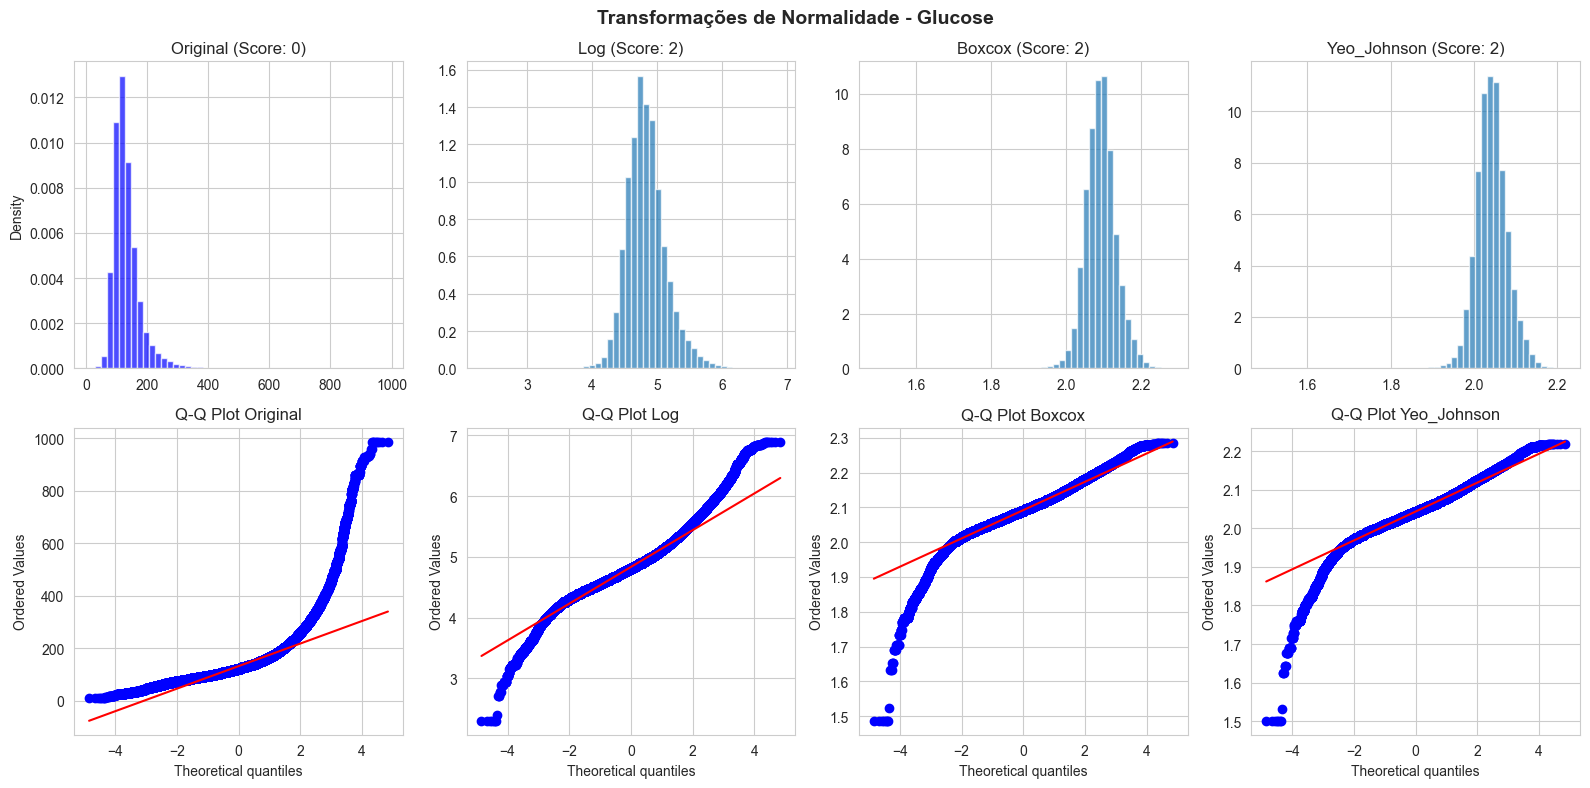

In [ ]:
# Troque o nome da variável abaixo e execute a célula para ver os Plots
column_name = 'Glucose'  # Exemplo: 'O2Sat', 'BUN', 'WBC', 'Hour', etc.
hour_results = validate_normality_transformations(
    data=X_train_clean[column_name], 
    column_name=column_name,
    sample_size=len(X_train_clean),  # Usar todos os dados
    plot_results=True
)

# Platelets -> box-cox
# WBC -> yeo-johnson
# BUN -> log
# MAP -> log
# Creatinine -> log
# Glucose -> log

### 10.4 Aplicar Transformações

In [44]:
# Platelets -> box-cox
# WBC -> yeo-johnson
# BUN -> log
# MAP -> log
# Creatinine -> log
# Glucose -> log

# Aplicar transformações recomendadas
df_transformed = df_clean.copy()
transformation_map = {
    'Platelets': 'boxcox',
    'WBC': 'yeo_johnson',
    'BUN': 'log',
    'MAP': 'log',
    'Creatinine': 'log',
    'Glucose': 'log'
}
for col, method in transformation_map.items():
    print(f"Aplicando {method} em {col}...")
    data_col = df_transformed[col].dropna()
    
    if method == 'log':
        df_transformed[col] = np.log(df_transformed[col])
    elif method == 'boxcox':
        transformed_data, lambda_bc = boxcox(data_col)
        df_transformed.loc[data_col.index, col] = transformed_data
    elif method == 'yeo_johnson':
        pt = PowerTransformer(method='yeo-johnson')
        transformed_data = pt.fit_transform(data_col.values.reshape(-1, 1)).flatten()
        df_transformed.loc[data_col.index, col] = transformed_data


Aplicando boxcox em Platelets...
Aplicando yeo_johnson em WBC...
Aplicando yeo_johnson em WBC...
Aplicando log em BUN...
Aplicando log em MAP...
Aplicando log em Creatinine...
Aplicando log em Glucose...
Aplicando log em BUN...
Aplicando log em MAP...
Aplicando log em Creatinine...
Aplicando log em Glucose...


## 11. Balanceamento de Classes

### 11.1 Variável Target Pré Balanceamento

Distribuição da Variável Target:
  Sem Sepsis (0.0): 1,084,642 (98.3%)
  Com Sepsis (1.0): 18,643 (1.7%)

Taxa de Desbalanceamento: 58.2:1

Distribuição por Paciente Único:
  Nunca teve Sepsis: 31,042 pacientes (92.8%)
  Teve Sepsis: 2,411 pacientes (7.2%)


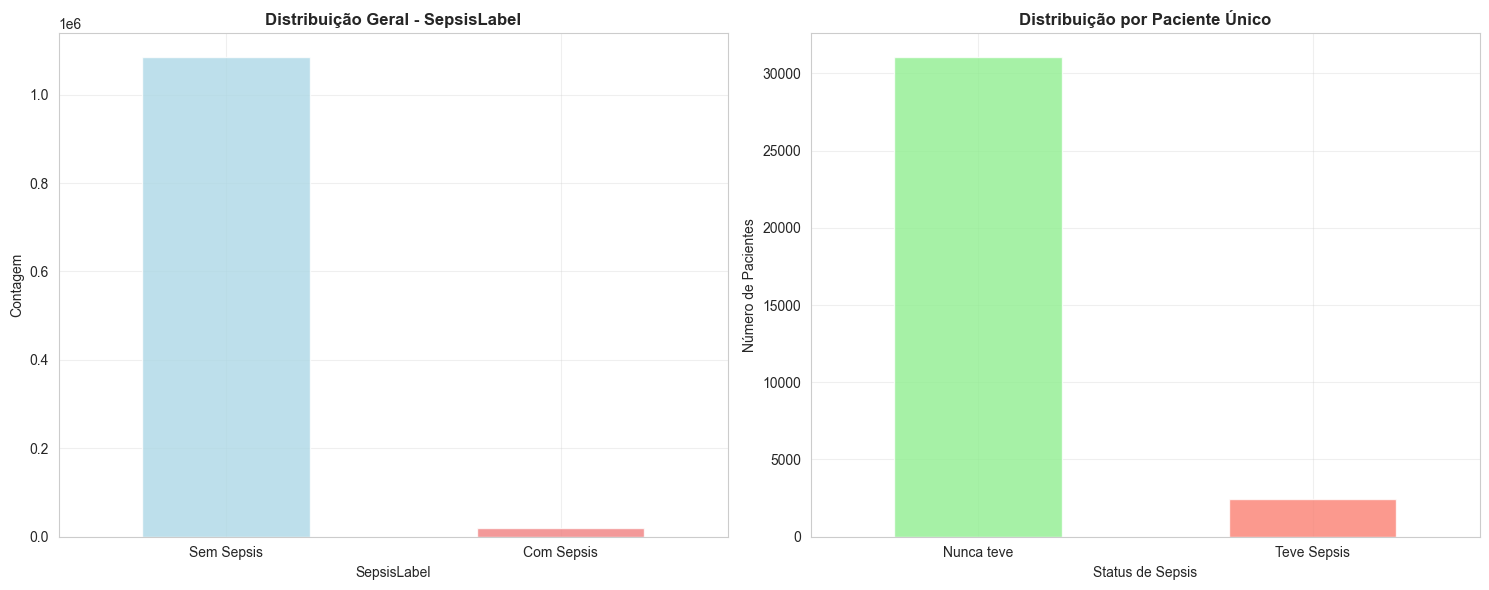

In [45]:
analyze_target_distribution(df_transformed)

### 11.2 Balancear usando sample() Considerando Coeficientes de Correlação

In [47]:
# Reduzir classe majoritaria
sepsis_count = df_transformed['SepsisLabel'].value_counts()
print(f"   Contagem antes da redução:\n{sepsis_count.to_string()}")
df_reduced = df_transformed.copy()
df_majority = df_reduced[df_reduced['SepsisLabel'] == 0]
df_minority = df_reduced[df_reduced['SepsisLabel'] == 1]
df_majority_reduced = df_majority.sample(frac=0.05, random_state=42)
df_balanced = pd.concat([df_majority_reduced, df_minority]).reset_index(drop=True)
sepsis_count_after = df_balanced['SepsisLabel'].value_counts()
print(f"   Contagem após a redução:\n{sepsis_count_after.to_string()}")

   Contagem antes da redução:
SepsisLabel
0.0    1084642
1.0      18643
   Contagem após a redução:
SepsisLabel
0.0    54232
1.0    18643


In [48]:
# Ver coeficientes de correlacao da versão com balanceamento para mensurar undersampling da classe negativa
corr_matrix = df_balanced.corr()
sepsis_corr = corr_matrix['SepsisLabel'].sort_values(ascending=False)
print("COEFICIENTES DE CORRELAÇÃO COM SEPSISLABEL:")
print(sepsis_corr.to_string())

COEFICIENTES DE CORRELAÇÃO COM SEPSISLABEL:
SepsisLabel    1.000000
Hour           0.372520
ICULOS         0.371635
Temp           0.160408
HR             0.150902
BUN            0.140816
Resp           0.136539
WBC            0.092181
Creatinine     0.080189
Glucose        0.037869
Gender         0.029185
O2Sat         -0.033850
Platelets     -0.035265
HospAdmTime   -0.055696
MAP           -0.062941
PATIENT_ID    -0.066140
Hct           -0.091609
Hgb           -0.095183


In [49]:
# Ver coeficientes de correlacao da versão completa (sem balanceamento)
corr_matrix = df_transformed.corr()
sepsis_corr = corr_matrix['SepsisLabel'].sort_values(ascending=False)
print("COEFICIENTES DE CORRELAÇÃO COM SEPSISLABEL:")
print(sepsis_corr.to_string())

COEFICIENTES DE CORRELAÇÃO COM SEPSISLABEL:
SepsisLabel    1.000000
Hour           0.157410
ICULOS         0.157094
Temp           0.052057
HR             0.046431
Resp           0.042887
BUN            0.042343
WBC            0.028816
Creatinine     0.024321
Glucose        0.011250
Gender         0.009175
Platelets     -0.010769
O2Sat         -0.011128
HospAdmTime   -0.016891
MAP           -0.018979
PATIENT_ID    -0.019225
Hct           -0.026677
Hgb           -0.027566


### 11.3 Variável Target Após Balanceamento

Distribuição da Variável Target:
  Sem Sepsis (0.0): 54,232 (74.4%)
  Com Sepsis (1.0): 18,643 (25.6%)

Taxa de Desbalanceamento: 2.9:1

Distribuição por Paciente Único:
  Nunca teve Sepsis: 23,697 pacientes (90.8%)
  Teve Sepsis: 2,411 pacientes (9.2%)


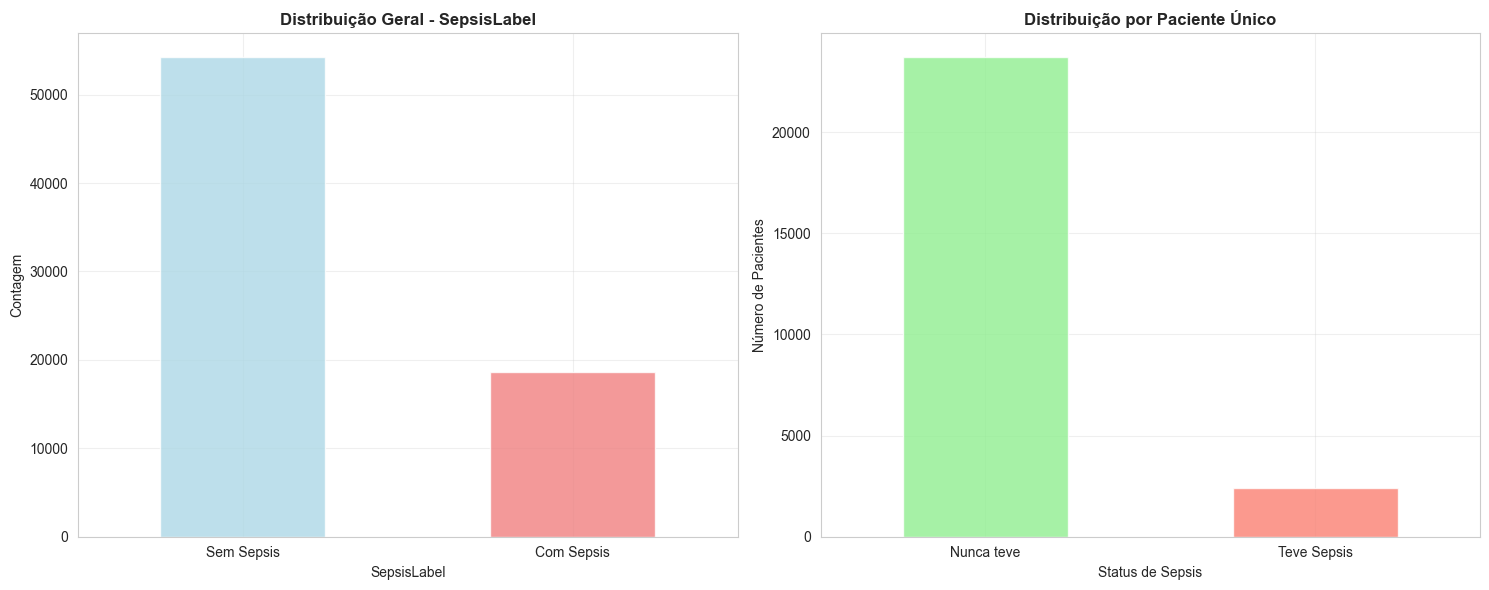

In [50]:
analyze_target_distribution(df_balanced)

## 12. Aplicar Normalização e Salvar Dados Processados

In [33]:
## Remover coluna PATIENT_ID antes de salvar
df_clean.drop('PATIENT_ID', axis=1, inplace=True)

In [ ]:
# Salvar dataset final limpo e transformado
df_final = df_balanced.copy()
scaler = StandardScaler()
numeric_cols_final = df_final.drop('SepsisLabel', axis=1).columns.tolist()
df_final[numeric_cols_final] = scaler.fit_transform(df_final[numeric_cols_final])       
df_final.to_csv(name+'_prep_v2.csv', index=False)

print(f"\nDataset final salvo como '{name}_prep_v2.csv' com shape {df_final.shape}")


✅ Dataset final salvo como 'dataset_sepsis_test_pid_prep_v2.csv' com shape (8180, 17)


In [50]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8180 entries, 0 to 8179
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Hour         8180 non-null   float64
 1   HR           8180 non-null   float64
 2   O2Sat        8180 non-null   float64
 3   Temp         8180 non-null   float64
 4   MAP          8180 non-null   float64
 5   Resp         8180 non-null   float64
 6   BUN          8180 non-null   float64
 7   Creatinine   8180 non-null   float64
 8   Glucose      8180 non-null   float64
 9   Hct          8180 non-null   float64
 10  Hgb          8180 non-null   float64
 11  WBC          8180 non-null   float64
 12  Platelets    8180 non-null   float64
 13  Gender       8180 non-null   float64
 14  HospAdmTime  8180 non-null   float64
 15  ICULOS       8180 non-null   float64
 16  SepsisLabel  8180 non-null   float64
dtypes: float64(17)
memory usage: 1.1 MB
